## Binomial tree model for option pricing

In this exercise within a derivatives class, the focus is on developing code to implement the binomial tree model for option pricing. 

The initial steps involve defining parameters such as the risk-neutral probability $q$, the risk-free interest rate $r$, the time increment $\delta$, the number of time steps $T$, and the factors for upward ($U$) and downward ($D$) stock price movements. These parameters are for setting up the model, where the initial stock price $S_0$ and the option's strike price $K$ are also specified.

Following the setup, the code constructs the binomial tree, representing potential future stock prices over discrete time intervals. This tree is a visual and computational representation of the different paths the stock price can take, each path affecting the option's value at maturity.

To determine the option prices, a European call option's payoff function is defined and applied at the tree's terminal nodes. The option values are then calculated recursively through backward induction, moving from the option's expiration towards the present. This method ensures the computation of option values at each node, reflecting the time value and intrinsic value throughout the option's life.

Moreover, the exercise includes calculating the quantities to hold at each node. These values indicate how many units of the underlying asset to buy or sell to neutralize the option's risk.

In [109]:
import numpy as np

# Define the input parameters for the binomial model
q = 0.5  # Risk-neutral probability of an upward movement
r = np.log(1.25)  # Risk-free interest rate, converted to continuous compounding
delta = 1  # Length of each time step
T = 3  # Number of time steps
gamma = np.exp(-r * delta)  # Discount factor for one time step
S0 = 8  # Initial stock price
U = 2  # Multiplicative upward movement factor
D = 0.5  # Multiplicative downward movement factor
K = 40  # Strike price

# Define the payoff function for the option
def H(S, K):
    return max(0, S - K)  # Payoff function for a European call option

# Initialize the stock price matrix with zeros
S = np.zeros((T + 1, T + 1))

# Initialize the option price matrix with zeros
P = np.zeros((T + 1, T + 1))

# Set the initial stock price at the root of the binomial tree
S[0][0] = S0

# Populate the stock price matrix
def populateS(S0, U, D, T, S):
    # Loop over each time step
    for j in range(1, T + 1):
        # Loop over each possible state at time j
        for i in range(j + 1):
            # Calculate the stock price at each node
            S[i][j] = S0 * (U ** (j - i)) * (D ** i)
    return S

# Call the function to populate the stock price matrix
S = populateS(S0, U, D, T, S)


# European Call Option

In [110]:
# Loop to initialize the option values at maturity based on the payoff function H
for i in range(1, T + 1):
    for j in range(i + 1):
        # Apply the payoff function H to the stock price at each final node to determine the option value at maturity
        P[j, i] = H(S[j, i], K)

# Backward induction to calculate the option prices at earlier nodes
for j in range(T - 1, -1, -1):  # Start from the second last column and move to the first column
    for i in range(j + 1):  # Iterate over all possible nodes at each time step
        # Calculate the option price at each node as the discounted expected value of its future outcomes
        # The expected value is computed as the weighted average of the option values in the next time step
        # The weights are the risk-neutral probabilities q and 1-q
        P[i, j] = gamma * q * P[i + 1, j + 1] + gamma * (1 - q) * P[i, j + 1]

In [111]:
print(P)

[[ 1.536  3.84   9.6   24.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]]


In [112]:
# Initialize the Delta matrix
Delta = np.zeros((T, T))

# Calculate the quantities to hold at each node
for t in range(T):
    for i in range(t + 1):
        Delta[i, t] = (P[i, t + 1] - P[i + 1, t + 1]) / (S[i, t + 1] - S[i + 1, t + 1])

print("Delta matrix (Quantities to hold):")
print(Delta)

Delta matrix (Quantities to hold):
[[0.32 0.4  0.5 ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]


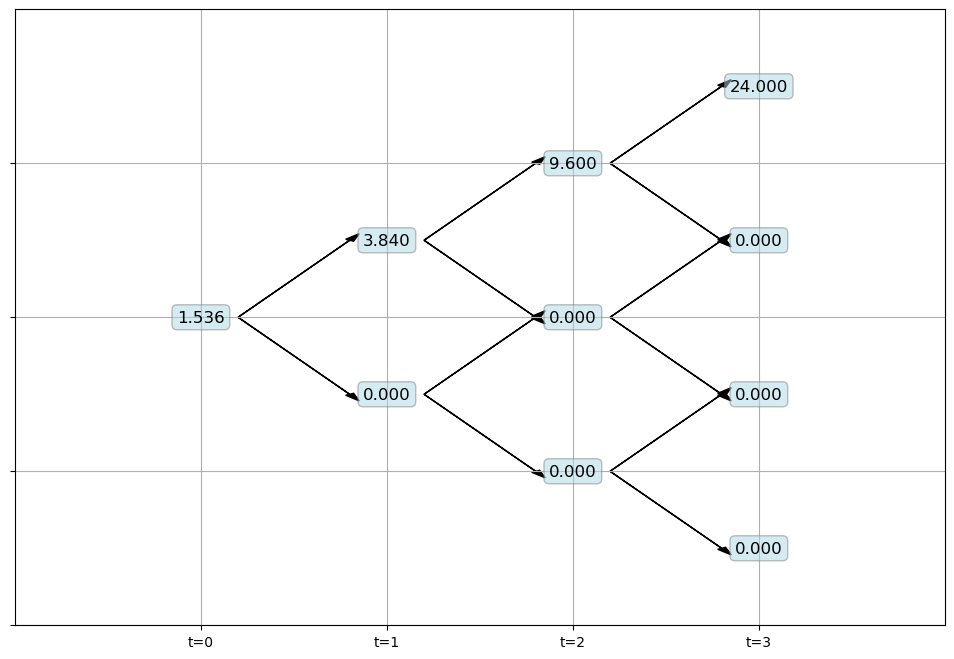

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis for the plot with increased size
fig, ax = plt.subplots(figsize=(12, 8))

# Define the maximum height based on the number of steps in the tree
max_height = 2 * (P.shape[0] - 1)

# Arrow adjustments for better visibility
arrow_head_width = 0.05
arrow_head_length = 0.1

# Plot each value of P and arrows in the binomial tree structure
for t in range(P.shape[1] - 1):  # Exclude the last column since it has no outgoing arrows
    for i in range(t + 1):
        # Calculate the current and next y positions, flipped vertically
        y_pos = max_height / 2 - (i - t / 2) * 2
        y_pos_up = max_height / 2 - ((i + 1) - (t + 1) / 2) * 2
        y_pos_down = max_height / 2 - (i - (t + 1) / 2) * 2

        # Add the value text
        ax.text(t, y_pos, f'{P[i, t]:.3f}', ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightblue', alpha=0.5))
        
        # Draw arrows for up and down movements with adjusted start and end points for clarity
        ax.arrow(t + 0.2, y_pos, (0.8 - 0.2), y_pos_up - y_pos, head_width=arrow_head_width, head_length=arrow_head_length, fc='k', ec='k')
        ax.arrow(t + 0.2, y_pos, (0.8 - 0.2), y_pos_down - y_pos, head_width=arrow_head_width, head_length=arrow_head_length, fc='k', ec='k')

# Add values for the last column, ensuring alignment
for i in range(P.shape[1]):
    y_pos = max_height / 2 - (i - (P.shape[1] - 1) / 2) * 2
    ax.text(P.shape[1] - 1, y_pos, f'{P[i, P.shape[1] - 1]:.3f}', ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightblue', alpha=0.5))

# Set limits, labels, and grid
ax.set_xlim(-1, P.shape[1])
ax.set_ylim(-1, max_height + 1)  # Updated limits for additional space above
ax.set_xticks(range(P.shape[1]))
ax.set_yticks(np.arange(-1, max_height + 1, 2))
ax.set_xticklabels([f't={t}' for t in range(P.shape[1])])
ax.set_yticklabels([])
ax.grid(True)

plt.show()


# European Put Option

In [115]:
# Define the payoff function for the option
def H(S, K):
    return max(0, K - S)  # Payoff function for a European put option

In [116]:
# Loop to initialize the option values at maturity based on the payoff function H
for i in range(1, T + 1):
    for j in range(i + 1):
        # Apply the payoff function H to the stock price at each final node to determine the option value at maturity
        P[j, i] = H(S[j, i], K)

# Backward induction to calculate the option prices at earlier nodes
for j in range(T - 1, -1, -1):  # Start from the second last column and move to the first column
    for i in range(j + 1):  # Iterate over all possible nodes at each time step
        # Calculate the option price at each node as the discounted expected value of its future outcomes
        # The expected value is computed as the weighted average of the option values in the next time step
        # The weights are the risk-neutral probabilities q and 1-q
        P[i, j] = gamma * q * P[i + 1, j + 1] + gamma * (1 - q) * P[i, j + 1]

In [117]:
print(P)

[[14.016 13.44   9.6    0.   ]
 [ 0.    21.6   24.    24.   ]
 [ 0.     0.    30.    36.   ]
 [ 0.     0.     0.    39.   ]]


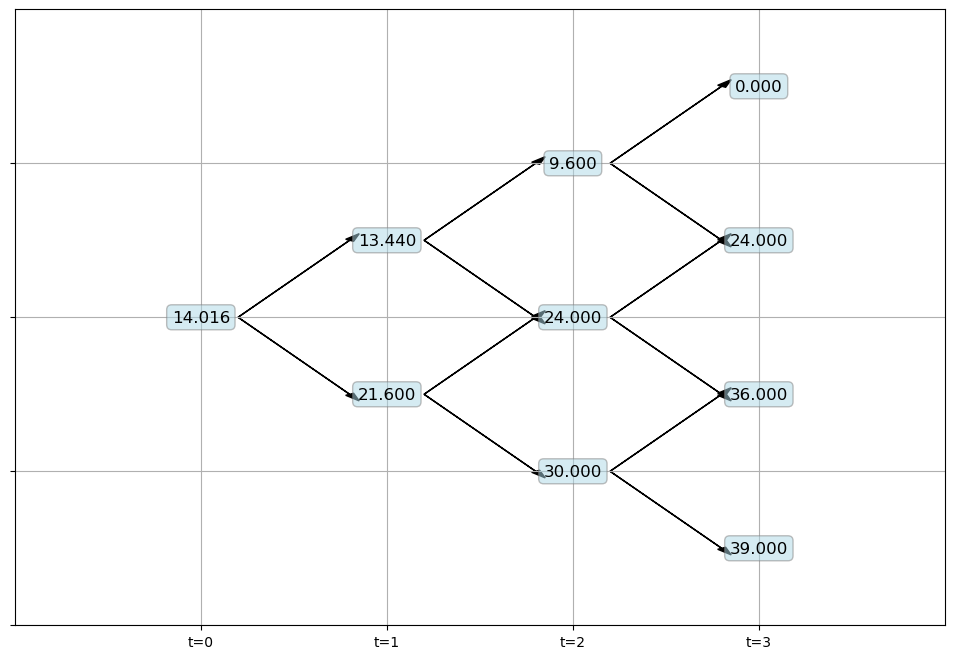

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis for the plot with increased size
fig, ax = plt.subplots(figsize=(12, 8))

# Define the maximum height based on the number of steps in the tree
max_height = 2 * (P.shape[0] - 1)

# Arrow adjustments for better visibility
arrow_head_width = 0.05
arrow_head_length = 0.1

# Plot each value of P and arrows in the binomial tree structure
for t in range(P.shape[1] - 1):  # Exclude the last column since it has no outgoing arrows
    for i in range(t + 1):
        # Calculate the current and next y positions, flipped vertically
        y_pos = max_height / 2 - (i - t / 2) * 2
        y_pos_up = max_height / 2 - ((i + 1) - (t + 1) / 2) * 2
        y_pos_down = max_height / 2 - (i - (t + 1) / 2) * 2

        # Add the value text
        ax.text(t, y_pos, f'{P[i, t]:.3f}', ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightblue', alpha=0.5))
        
        # Draw arrows for up and down movements with adjusted start and end points for clarity
        ax.arrow(t + 0.2, y_pos, (0.8 - 0.2), y_pos_up - y_pos, head_width=arrow_head_width, head_length=arrow_head_length, fc='k', ec='k')
        ax.arrow(t + 0.2, y_pos, (0.8 - 0.2), y_pos_down - y_pos, head_width=arrow_head_width, head_length=arrow_head_length, fc='k', ec='k')

# Add values for the last column, ensuring alignment
for i in range(P.shape[1]):
    y_pos = max_height / 2 - (i - (P.shape[1] - 1) / 2) * 2
    ax.text(P.shape[1] - 1, y_pos, f'{P[i, P.shape[1] - 1]:.3f}', ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightblue', alpha=0.5))

# Set limits, labels, and grid
ax.set_xlim(-1, P.shape[1])
ax.set_ylim(-1, max_height + 1)  # Updated limits for additional space above
ax.set_xticks(range(P.shape[1]))
ax.set_yticks(np.arange(-1, max_height + 1, 2))
ax.set_xticklabels([f't={t}' for t in range(P.shape[1])])
ax.set_yticklabels([])
ax.grid(True)

plt.show()
